# Workshop 2: Image Segmentation

In this workshop we will how to implement a segmentation model based in UNet and ResNet with [fastai](https://https://www.fast.ai/). The structure of the workshop will be as follows:


1.   Load and explore data
2.   Train the model
3.   Evaluate results

[Reference](https://https://course.fast.ai/videos/?lesson=3)



# Don't forget to configure the execution environment to run in GPU

# Download dataset

In [ ]:
# Import fastai
from fastai.vision import *

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Download dataset
path = untar_data(URLs.CAMVID)

In [ ]:
path

PosixPath('/root/.fastai/data/camvid')

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [ ]:
(path / "images").ls()

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00270.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f02580.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f02190.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08081.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01080.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03780.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008490.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06030.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_006750.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f04980.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_00870.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07110.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_009300.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008790.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f02610.png'),
 PosixPat

In [ ]:
# Number of images
len((path / "images").ls())

702

torch.Size([3, 720, 960])


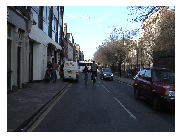

In [ ]:
# Show image and size
img_name = "0016E5_07770.png"
img = open_image(path / "images" / img_name)
img.show()
print(img.shape)

In [ ]:
(path / "labels").ls()

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_007020_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07963_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04590_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03330_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_06450_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08011_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07860_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_00600_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_007560_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01890_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_006810_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03360_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08190_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_00780_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07

In [ ]:
# Number of masks
len((path / "labels").ls())

701

torch.Size([1, 720, 960])


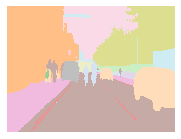

In [ ]:
# Show mask and size
mask_name = img_name.split(".")[0] + "_P.png"
mask = open_mask(path / "labels" / mask_name)
mask.show()
print(mask.shape)

In [ ]:
# Show mask matrix
mask.data

tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17]]])

In [ ]:
# Show different values of mask
mask.data.unique()

tensor([ 2,  4,  5,  6,  7,  8,  9, 10, 12, 14, 16, 17, 19, 21, 22, 24, 26, 27,
        30, 31])

In [ ]:
# Show label names
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
# Show number of classes
len(codes)

32

# 1. Load and explore data

In [ ]:
# Function to get mask path from images path
def img_to_mask(img_path):
  mask_dir = path / "labels"
  mask_name = img_path.name.split(".")[0] + "_P.png"
  mask_path = mask_dir / mask_name
  return mask_path

In [ ]:
# Configure data source
img_path = path / "images"
src = (SegmentationItemList.from_folder(img_path)
       .split_by_fname_file('../valid.txt')
       .label_from_func(img_to_mask, classes=codes))

In [ ]:
# Configure data processing
orig_size = np.array(img.shape[1:])
size = orig_size // 4
batch_size = 32
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))

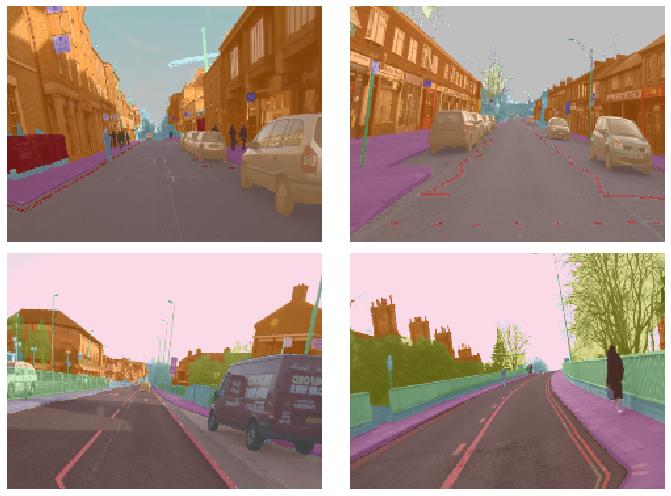

In [ ]:
# Show batch of training data with masks overlaped
data.show_batch(2, figsize=(10,7))

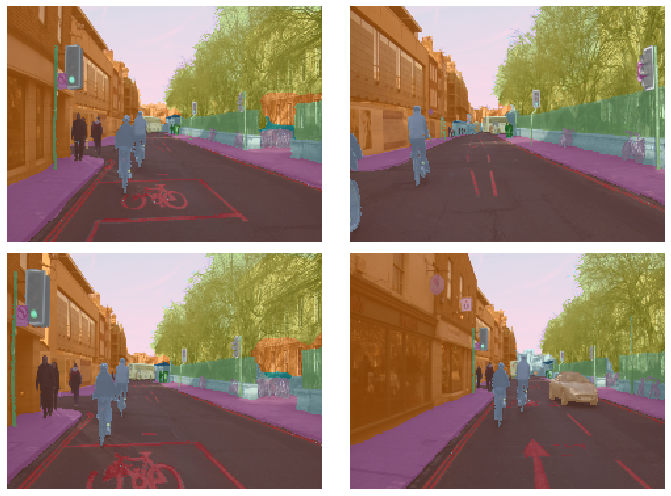

In [ ]:
# Show batch of training validation with masks overlaped
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# 2. Train the model

In [ ]:
# Metric for camvid dataset
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
# Initialize learner
metrics=acc_camvid
learn = unet_learner(data, models.resnet18, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


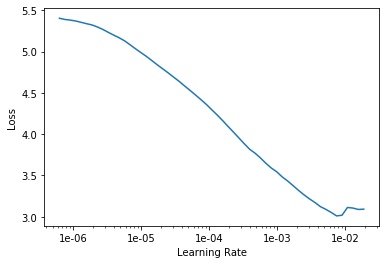

In [ ]:
# Find learning rate
lr_find(learn)
learn.recorder.plot()

In [ ]:
# Set learning rate
lr = 1e-3

In [ ]:
# Train 10 epochs
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,2.835779,1.803921,0.544505,00:37
1,2.000506,1.152873,0.640611,00:35
2,1.627610,1.130674,0.675127,00:35
3,1.344184,0.733816,0.832634,00:34
4,1.127241,0.675876,0.834094,00:34
5,0.972573,0.582118,0.849784,00:35
6,0.863636,0.611905,0.840193,00:35
7,0.780227,0.550094,0.851091,00:35
8,0.716468,0.533481,0.852263,00:35
9,0.670577,0.529679,0.855340,00:35


In [ ]:
# Save the model
learn.save("score-8553")

In [ ]:
# Unfreeze all the network
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


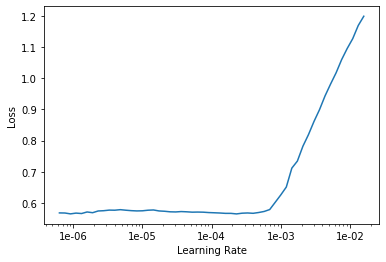

In [ ]:
# Find learning rate
lr_find(learn)
learn.recorder.plot()

In [ ]:
# Set learning rate
lr = 1e-4

In [ ]:
# Train 10 epochs
learn.fit_one_cycle(10, slice(lr/100, lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.569637,0.532431,0.854697,00:35
1,0.565412,0.518625,0.855916,00:35
2,0.561449,0.486021,0.865699,00:35
3,0.556026,0.481580,0.866386,00:35
4,0.545072,0.467316,0.870064,00:35
5,0.531837,0.463564,0.870583,00:34
6,0.520032,0.453497,0.871173,00:35
7,0.508826,0.445548,0.873808,00:34
8,0.499252,0.451181,0.872414,00:35
9,0.492112,0.446099,0.873967,00:34


In [ ]:
learn.save('score-8739')

# 3. Evaluate results

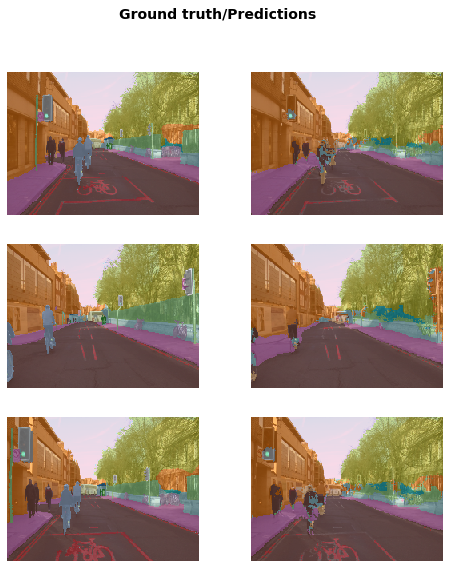

In [ ]:
# Show validation predictions
learn.show_results(rows=3, figsize=(8,9))

# Exercise 1: Re-train the model with orig_size // 2

In [ ]:
# Configure data processing


In [ ]:
# Configure learner with new data and freeze conv layers


In [ ]:
# Load model


In [ ]:
# Find learning rate


In [ ]:
# Set learning rate


In [ ]:
# Train 10 epochs


In [ ]:
# Unfreeze all the network


In [ ]:
# Find learning rate


In [ ]:
# Set learning rate


In [ ]:
# Train 10 epochs


In [ ]:
# Save the model


In [ ]:
# Show validation predictions


# Exercise 2: Train a model based in ResNet34